In [1]:
import numpy as np
from model import DCGAN
from utils import pp, visualize, to_json, show_all_variables, expand_path, timestamp
from ops import batch_norm

import tensorflow as tf
import cv2
import time
import io
import IPython.display
import PIL.Image
import matplotlib.pyplot as plt

In [2]:
def imshow(a, im_size=256, format='png', jpeg_fallback=True, filename=None):
  if a.dtype != np.uint8:
      a = a*255
  a = np.asarray(a, dtype=np.uint8)
  a = cv2.resize(a, (a.shape[1], a.shape[0]))

  str_file = io.BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
    if filename:
        size = (a.shape[1]//2, a.shape[0]//2)
        im = PIL.Image.fromarray(a)
        im.thumbnail(size,PIL.Image.ANTIALIAS)
        im.save('{}.{}'.format(filename, format))
        
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

In [3]:
def imgrid(imarray, cols=5, pad=1):
  if imarray.dtype != np.uint8:
    raise ValueError('imgrid input imarray must be uint8')
  pad = int(pad)
  assert pad >= 0
  cols = int(cols)
  assert cols >= 1
  N, H, W, C = imarray.shape
  rows = int(np.ceil(N / float(cols)))
  batch_pad = rows * cols - N
  assert batch_pad >= 0
  post_pad = [batch_pad, pad, pad, 0]
  pad_arg = [[0, p] for p in post_pad]
  imarray = np.pad(imarray, pad_arg, 'constant', constant_values=255)
  H += pad
  W += pad
  grid = (imarray
          .reshape(rows, cols, H, W, C)
          .transpose(0, 2, 1, 3, 4)
          .reshape(rows*H, cols*H, C))
  if pad:
    grid = grid[:-pad, :-pad]
  return grid

In [4]:
initializer = tf.global_variables_initializer()
config = tf.ConfigProto(log_device_placement=False)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(initializer)

In [5]:
def initialize_uninitialized(sess):
    global_vars          = tf.global_variables()
    is_not_initialized   = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]

    print([str(i.name) for i in not_initialized_vars]) # only for testing
    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))
        return not_initialized_vars

In [6]:
checkpoint_dir = "./out/20190813.180154_data_mnist_x28.z100.uniform_signed.y28.b64_without_aug_5px_shift/checkpoint"
sample_dir = "./out/20190813.180154_data_mnist_x28.z100.uniform_signed.y28.b64_without_aug_5px_shift/sample"
num_samples = 64

flags = tf.app.flags
flags.DEFINE_integer("epoch", 25, "Epoch to train [25]")
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_float("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", num_samples, "The size of batch images [64]")
flags.DEFINE_integer("input_height", 28, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_width", 28, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
flags.DEFINE_integer("output_height", 28, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_width", 28, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "mnist", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("data_dir", "./data", "path to datasets [e.g. $HOME/data]")
flags.DEFINE_string("out_dir", "./out", "Root directory for outputs [e.g. $HOME/out]")
flags.DEFINE_string("out_name", "", "Folder (under out_root_dir) for all outputs. Generated automatically if left blank []")
# flags.DEFINE_string("checkpoint_dir", "checkpoint", "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
flags.DEFINE_string("checkpoint_dir", checkpoint_dir, "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
# flags.DEFINE_string("sample_dir", "samples", "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_string("sample_dir", sample_dir, "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("crop", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
flags.DEFINE_boolean("export", False, "True for exporting with new batch size")
flags.DEFINE_boolean("freeze", False, "True for exporting with new batch size")
flags.DEFINE_integer("max_to_keep", 1, "maximum number of checkpoints to keep")
flags.DEFINE_integer("sample_freq", 200, "sample every this many iterations")
flags.DEFINE_integer("ckpt_freq", 200, "save checkpoint every this many iterations")
flags.DEFINE_integer("z_dim", 100, "dimensions of z")
flags.DEFINE_integer("y_dim", 10, "choose dimensions of y to be 10")
flags.DEFINE_string("z_dist", "uniform_signed", "'normal01' or 'uniform_unsigned' or uniform_signed")
flags.DEFINE_boolean("G_img_sum", False, "Save generator image summaries in log")
#flags.DEFINE_integer("generate_test_images", 100, "Number of images to generate during test. [100]")
# only for jupyter:
flags.DEFINE_string('f', '', 'kernel')

FLAGS = flags.FLAGS

In [7]:
# dcgan = DCGAN(
#     sess,
#     input_width=28,
#     input_height=28,
#     output_width=28,
#     output_height=28,
#     batch_size=64,
#     sample_num=64,
#     y_dim=10,
#     z_dim=100,
#     dataset_name='mnist',
#     input_fname_pattern='*.jpg',
#     crop=False,
#     checkpoint_dir='20190813.180154_data_mnist_x28.z100.uniform_signed.y28.b64/checkpoint',
# #     out_name='20190813.180154_data_mnist_x28.z100.uniform_signed.y28.b64',
#     sample_dir='samples',
#     data_dir='./data',
#     out_dir='./out',
#     max_to_keep=1)
dcgan = DCGAN(
    sess,
    input_width=FLAGS.input_width,
    input_height=FLAGS.input_height,
    output_width=FLAGS.output_width,
    output_height=FLAGS.output_height,
    batch_size=FLAGS.batch_size,
    sample_num=num_samples,
    y_dim=FLAGS.y_dim,
    z_dim=FLAGS.z_dim,
    dataset_name=FLAGS.dataset,
    input_fname_pattern=FLAGS.input_fname_pattern,
    crop=FLAGS.crop,
    checkpoint_dir=FLAGS.checkpoint_dir,
    sample_dir=FLAGS.sample_dir,
    data_dir=FLAGS.data_dir,
    out_dir=FLAGS.out_dir,
    max_to_keep=FLAGS.max_to_keep)

load_success, load_counter = dcgan.load(FLAGS.checkpoint_dir)
if not load_success:
    raise Exception("Checkpoint not found in " + FLAGS.checkpoint_dir)

 [*] Reading checkpoints... ./out/20190813.180154_data_mnist_x28.z100.uniform_signed.y28.b64_without_aug_5px_shift/checkpoint
INFO:tensorflow:Restoring parameters from ./out/20190813.180154_data_mnist_x28.z100.uniform_signed.y28.b64_without_aug_5px_shift/checkpoint/model.b64-27200
 [*] Success to read model.b64-27200


In [8]:
# visualize(sess, dcgan, FLAGS, 1, FLAGS.sample_dir)


In [21]:
z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

# y = np.random.choice(10, num_samples)
y = np.ones(64,dtype=np.uint8)
y_one_hot = np.zeros((num_samples, 10))
y_one_hot[np.arange(num_samples), y] = 1
print(y_one_hot)

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0.

[[-5 -4 -3 -2 -1  0  1  2  3  4  5]]


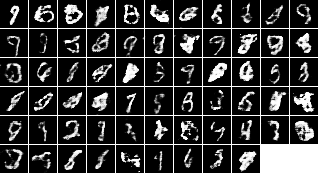

In [22]:
alpha = np.arange(-5,6,1).reshape((11,1))
# alpha = np.zeros([11,1])
print(np.transpose(alpha))
samples = sess.run(dcgan.G, feed_dict = {dcgan.z: z_sample, dcgan.y: y_one_hot})
imshow(imgrid(np.uint8(samples*255), cols=11))



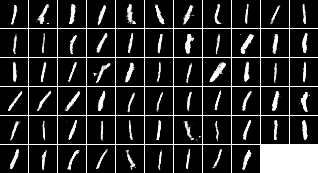

In [23]:
samples = sess.run(dcgan.sampler, feed_dict = {dcgan.z: z_sample, dcgan.y: y_one_hot})
imshow(imgrid(np.uint8(samples*255), cols=11))

In [ ]:
# ## explicitly get transformed image by using w:
# alpha = np.arange(-5,6,1).reshape((11,1))
# print(np.transpose(alpha))

# w_best = dcgan.w.eval(sess)
# z_sample_new = z_sample + alpha * w_best
# samples_new = sess.run(dcgan.G_new, feed_dict = {dcgan.z_new: z_sample_new, dcgan.y: y_one_hot})
# print('G:')
# imshow(imgrid(np.uint8(samples*255), cols=11))
# targets,masks = dcgan.get_target_np(samples, alpha)
# print('Target:')
# imshow(imgrid(np.uint8(targets*255), cols=11))
# print('Transformed:')
# imshow(imgrid(np.uint8(samples_new*255), cols=11))


In [ ]:
# test: show imgs 
a = np.arange(-5,6,1).reshape((11,1))
ns = num_samples
categories = np.arange(0,10,1)
y = 5
y_one_hot = np.zeros((ns, FLAGS.y_dim))
y_one_hot[np.arange(ns), y] = 1
print(y_one_hot)

for i in range(1):
    samples, samples_new = sess.run([dcgan.G, dcgan.G_new], 
                                    feed_dict = {dcgan.z: z_sample, 
                                                 dcgan.y: y_one_hot, 
                                                 dcgan.alpha: np.expand_dims(np.tile(a[i],11),axis=1)})
imshow(imgrid(np.uint8(samples*255), cols=a.shape[0]))


In [ ]:
for c in range(categories.shape[0]):

    ims_target = []
    ims_transformed = []

    z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
    y = categories[c]
    y_one_hot = np.zeros((ns, FLAGS.y_dim))
    y_one_hot[np.arange(ns), y] = 1

    for i in range(a.shape[0]):
        samples, samples_new = sess.run([dcgan.G, dcgan.G_new], 
                                        feed_dict = {dcgan.z: z_sample, 
                                                     dcgan.y: y_one_hot, 
                                                     dcgan.alpha: np.expand_dims(np.tile(a[i],11),axis=1)})
        targets, masks = dcgan.get_target_np(samples, a)
        print('Target:')
        imshow(imgrid(np.uint8(targets*255), cols=a.shape[0]))
        print('Transformed:')
        imshow(imgrid(np.uint8(samples_new*255), cols=a.shape[0]))
        
        ims_target.append(targets)
        ims_transformed.append(samples_new)
    

#     for j in range(min(ns, 3)):
#         top_row = np.stack([x[j, :, :, :] for x in ims_target], axis=0)
#         top_row = np.uint8 (np.clip(((top_row + 1) / 2.0) * 256, 0, 255))
#         bottom_row = np.stack([x[j, :, :, :] for x in ims_zoomed], axis=0)
#         bottom_row = np.uint8(np.clip(((bottom_row + 1) / 2.0) * 256, 0, 255))
#         # add a green stripe down the center for alignment
#         _, _, width, _ = top_row.shape
#         top_row[:, :, width//2-1:width//2+3, 1] = 255
#         bottom_row[:, :, width//2-1:width//2+3, 1] = 255
#         ims.append(np.concatenate((top_row,bottom_row), axis=0))
#     ims = np.concatenate(ims, axis=0)
#     imshow(imgrid(ims, cols=len(a)), fi